# EcoFOCIpy PostQC example to update older netcdf file


## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import pandas as pd
import xarray as xr
import datetime
import EcoFOCIpy.io.erddap as erddap

import EcoFOCIpy.metaconfig.load_config as load_config

In [8]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2024/Moorings/24bs8a/working/'
filename = '24bs8a_eco_0019m.nc'

### Post Manual QC load data and rebuild nc file

- using excel for a few points or a dynamic web map for multiple (a tool on ecofoci-field.pmel.noaa.gov) or any other method to identify spikes
- remove values above 32psu and below 30psu

**NOTE** if you use excel, be cautious about how your time is formatted (its important) - use custom formatting and make it of the form `yyyy-mm-ddTHH:MM:SSZ` to assure proper read in to xarray

*TODO:* use erddap hosted data 

In [14]:
# this loads the initial working netcdf file
wop_nc_qc = xr.load_dataset(user_data_dir+filename)

In [15]:
wop_nc_qc = wop_nc_qc.sel({'time':slice('2010-01-01','2025-10-30')})

### Update global attributes

In [16]:
wop_nc_qc.attrs.update({'QC_indicator': 'ProbablyGood'})
try:
    wop_nc_qc.attrs.update({'history':(wop_nc_qc.history + "\nQC'd: "+ str(datetime.datetime.today()))})
except:
    wop_nc_qc['history'] = f"history \nQC'd: {datetime.datetime.today()}"

In [17]:
wop_nc_qc.attrs.update({'date_modified':str(datetime.datetime.today())})

In [18]:
wop_nc_qc.to_netcdf(user_data_dir+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_66740/664318075.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'hours' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  wop_nc_qc.to_netcdf(user_data_dir+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})


In [19]:
wop_nc_qc

<xarray.Dataset> Size: 142kB
Dimensions:             (time: 8903, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time                (time) datetime64[ns] 71kB 2024-08-08T22:00:00 ... 20...
  * latitude            (latitude) float64 8B 62.2
  * longitude           (longitude) float64 8B -174.7
  * depth               (depth) float64 8B 20.0
Data variables:
    chlor_fluorescence  (time, depth, latitude, longitude) float64 71kB 1.186...
Attributes: (12/15)
    Latitude_DegMMddW:                      62 11.88 N
    Longitude_DegMMddN:                     174 39.78 W
    MooringID:                              24BS-8A
    platform_deployment_date:               2024-08-08T21:35:00Z
    platform_deployment_cruise_name:        SKQ202412S
    platform_recovery_date:                 2025-08-14T20:39:00Z
    ...                                     ...
    InstrumentSerialNumber:                 1984
    InstrumentType:                         Eco-Fluorometer FLSB
    date_created:                           2025-08-16T05:39:11Z
    date_modified:                          2025-08-18 14:14:05.114273
    QC_indicator:                           ProbablyGood
    history:                                Trimmed to deployment.\nTrimmed t...

## Plot against CTD if necessary

In [29]:
%run '../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import pandas as pd
import EcoFOCIpy.io.erddap as erddap

url = "http://ecofoci-field.pmel.noaa.gov:8082/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [30]:
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='skq202214s',qclevel='preliminary',concastno='033')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='skq202312s',qclevel='preliminary',concastno='060')

In [31]:
#drop units from names
depcast.columns = [x.split()[0] for x in depcast.columns]
reccast.columns = [x.split()[0] for x in reccast.columns]

some variable names switch between preliminary and final... this will eventually be resolved

In [32]:
depth = filename.split('.nc')[0].split('_')[-1]
depth = int(depth.split('m')[0])

AttributeError: 'Dataset' object has no attribute 'temperature'

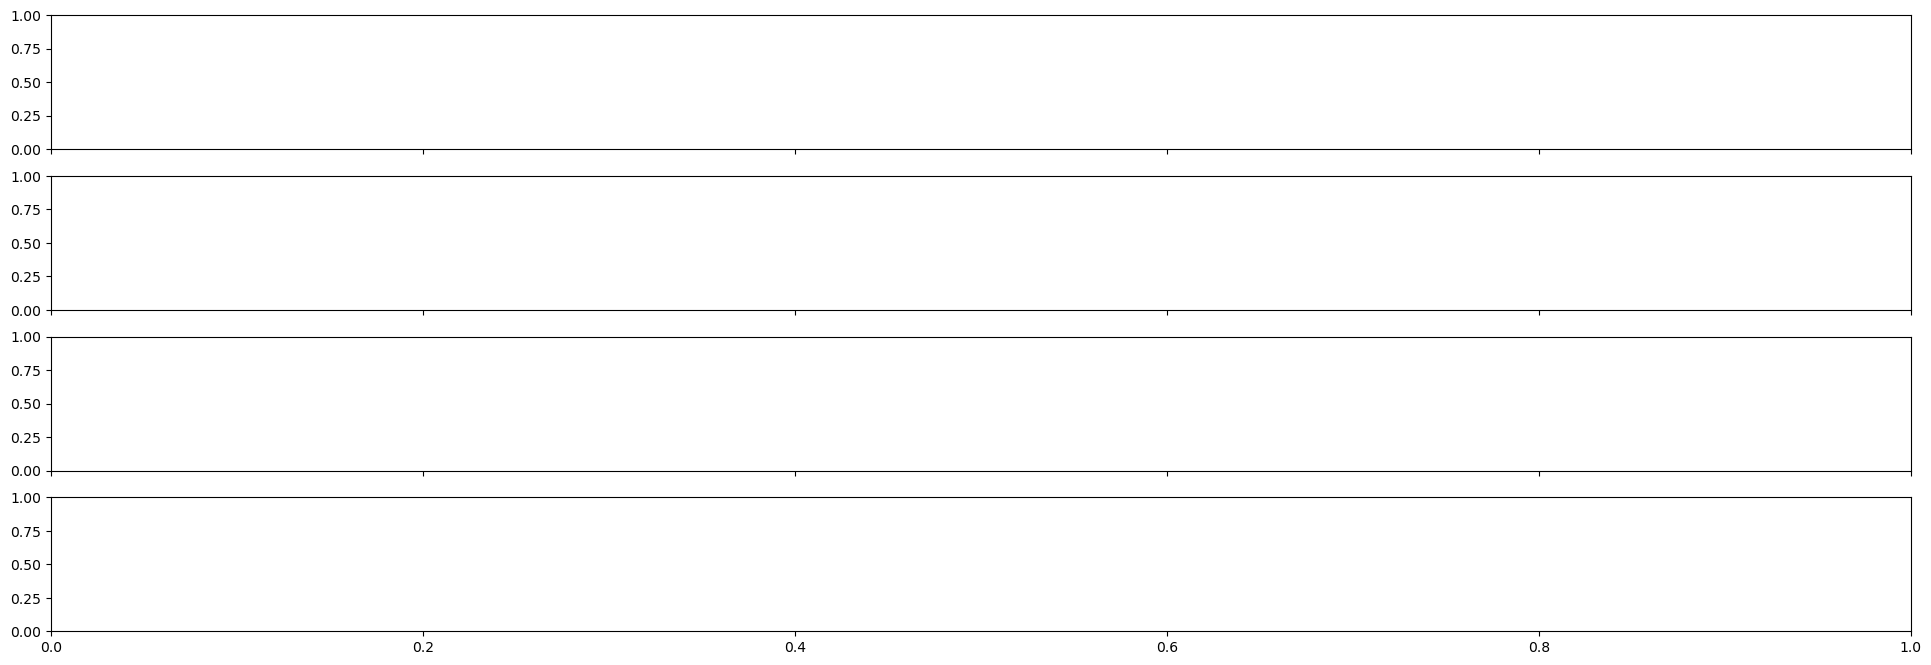

In [33]:

fig, ax = plt.subplots(4,figsize=(24, 8),sharex=True)
wop_nc_qc.temperature.plot(ax=ax[0],color='r')
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['T_28'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['T_28'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')
ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['T_28'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['T_28'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')

wop_nc_qc.salinity.plot(ax=ax[1],color='b')
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['S_41'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['S_41'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')
ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['S_41'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['S_41'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')

wop_nc_qc.oxy_conc_umkg.plot(ax=ax[2],color='orange')
# wop_nc_qc.oxy_conc.plot(ax=ax[2],color='orange',alpha=0.5)
ax[2].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['O_65'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[2].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['O_65'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')
ax[2].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['O_65'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[2].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['O_65'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')

# wop_nc_qc.par.plot(ax=ax[3],color='orange')
# ax[3].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']), 
#         depcast[depcast['pressure'] == depth]['PAR_905'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
# ax[3].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
#         depcast[depcast['pressure'] == depth]['PAR_905'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='black')
# ax[3].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['PAR_905'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
# ax[3].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['PAR_905'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='black')

# xfmt = mdates.DateFormatter('%d-%b')
ax[3].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[3].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[3].xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax[3].xaxis.set_major_formatter(DateFormatter(''))
ax[3].xaxis.set_tick_params(which='major', pad=3)
ax[3].xaxis.set_tick_params(which='minor', pad=5)

fig.savefig(f"images/{filename.replace('nc','_tempsalCal.png')}")